In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from numpy.fft import fft, ifft
from IPython.display import Audio
from scipy import signal
from ipykernel import kernelapp as app

In [127]:
FRAME_SIZE = 1024

In [118]:
numFrames = 234
crowd_filter = np.zeros(FRAME_SIZE)
ss = np.zeros((570 ,FRAME_SIZE))
nn = np.zeros((570 ,FRAME_SIZE))

In [129]:
def voice_decider(frame):
    isVoiced = 0

    energy = 0
    
    for i in range(len(frame)):
        energy = energy + frame[i]*frame[i]

    #print(energy)
    #if(energy>70000000):
    #    isVoiced = 1
        
    if(energy>990000000):
        isVoiced = 1
        
    return isVoiced

In [120]:
total = 0

for i in range(5):
    Fs, speech = read('Ky-'+str(i+1)+'.wav')
    Fs1, noise = read('Engine-'+str(i+1)+'.wav')
    
    for j in range(numFrames):
        speech_data = speech[j*FRAME_SIZE : (j+1)*FRAME_SIZE]
    
        if(voice_decider(speech_data.astype(float)) == 0):
            continue
        
        noise_data = noise[j*FRAME_SIZE : (j+1)*FRAME_SIZE]
        
        speech_average = np.mean(speech_data)
        speech_std = np.std(speech_data)
        speech_data = (speech_data - speech_average)/speech_std
        
        noise_average = np.mean(noise_data)
        noise_std = np.std(noise_data)
        noise_data = (noise_data - noise_average)/noise_std
        
        speech_spectrum = np.fft.fft(speech_data)
        noise_spectrum = np.fft.fft(noise_data)
        
        speech_spectrum = np.abs(speech_spectrum)
        speech_spectrum = np.power(speech_spectrum, 2)
        ss[total, :] = speech_spectrum
        
        noise_spectrum = np.abs(noise_spectrum)
        noise_spectrum = np.power(noise_spectrum, 2)
        nn[total, :] = noise_spectrum
            
        total = total+1    
            

In [121]:
for i in range(FRAME_SIZE):
    s = np.mean(ss[:, i])
    n = np.mean(nn[:, i])
    
    crowd_filter[i] = ((s) / (s+n))**2

In [166]:
# Testing trained crowd filter
Fs, data = read('test_audio.wav')
numFrames = int(len(data) / FRAME_SIZE)
output_crowd = np.zeros(len(data))
window_num = 0
noise_spectrum = np.zeros(FRAME_SIZE)

In [167]:
for i in range(numFrames):
    frame = data[i * FRAME_SIZE : ((i+1) * FRAME_SIZE)]
    
    if(voice_decider(frame.astype(float)) == 0):
        print(i)
        curFft = np.abs(np.fft.fft(frame))
        noise_spectrum = (noise_spectrum * window_num + curFft)/(window_num + 1)
        window_num = window_num + 1
        output_crowd[i * FRAME_SIZE : ((i+1) * FRAME_SIZE)] = frame/10000
        continue
    
    DFT = np.fft.fft(frame)
    DFT1 = DFT
    
    for t in range(FRAME_SIZE):
        if (DFT1[t] != 0):
            DFT1[t] = (np.abs(DFT[t]) - noise_spectrum[t])*DFT[t]/np.abs(DFT1[t])
        
        s = np.abs(DFT1[t])*np.abs(DFT1[t])
        n = noise_spectrum[t]*noise_spectrum[t]
        
        if(s+n != 0):
            crowd_filter[t] = (s/(s+n))**2
        else:
            crowd_filter[t] = 0
    #print(crowd_filter)
    
    DFT1 = np.multiply(DFT, crowd_filter)
    
    output_crowd[i * FRAME_SIZE : ((i+1) * FRAME_SIZE)] = np.fft.ifft(DFT1)

/Users/lihongyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


377


In [163]:
# Play out the original audio
Audio(data, rate=Fs)

In [164]:
# Play out the processed audio
Audio(output_crowd, rate=Fs)

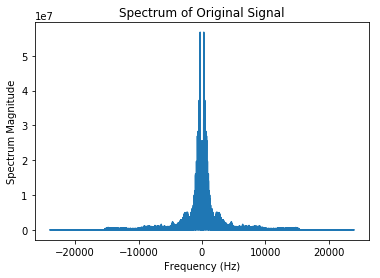

In [160]:
DFT = np.fft.fft(data)

#Generate the frequency values in horizontal axis
freq = np.fft.fftfreq(data.size, 1/Fs)
plt.plot(freq,abs(DFT))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectrum Magnitude')
plt.title('Spectrum of Original Signal')
plt.show()

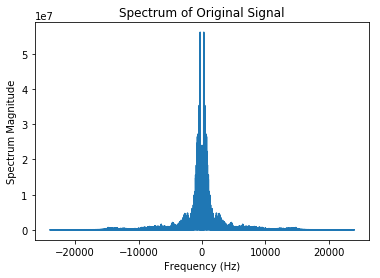

In [161]:
DFT = np.fft.fft(output_crowd)

#Generate the frequency values in horizontal axis
freq = np.fft.fftfreq(data.size, 1/Fs)
plt.plot(freq,abs(DFT))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectrum Magnitude')
plt.title('Spectrum of Original Signal')
plt.show()

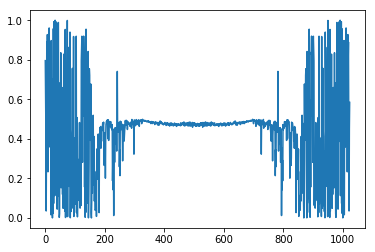

In [141]:
plt.plot(crowd_filter)
plt.show()

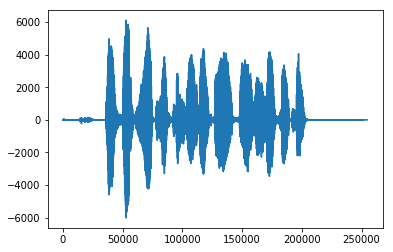

In [12]:
Fs, data = read('Ky-1.wav')
plt.plot(data)
plt.show()

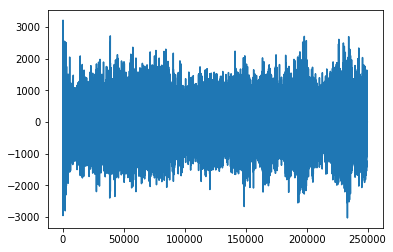

In [13]:
Fs, data = read('Crowd-1.wav')
plt.plot(data)
plt.show()

In [52]:
print(total)

570
